<a href="https://colab.research.google.com/github/karolinakuligowska/TMSMM_codes/blob/main/TMSMM_class12_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# neural nets for text mining
###
###
###

# example from eliotbar
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils import to_categorical # fix for colab (instead of: from keras.utils.np_utils import to_categorical)


%matplotlib inline

In [3]:
df = pd.read_csv("GrammarandProductReviews.csv")

In [4]:
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


(array([ 3701.,     0.,  1833.,     0.,     0.,  4369.,     0., 14598.,
            0., 46543.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

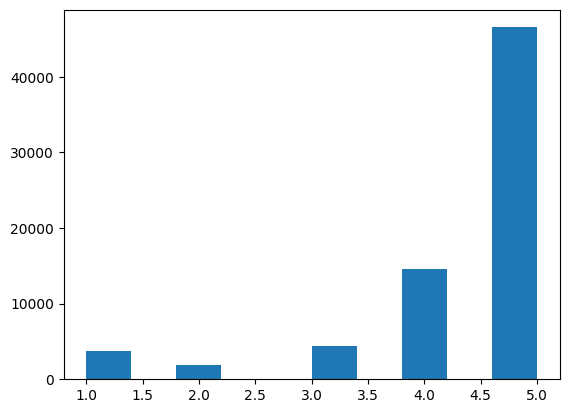

In [5]:
# We will only consider the text of the reviews and the ratings.
# We are going to make an approximation in order to predict from the text the satisfaction level of the customer.

plt.hist(df['reviews.rating'])

In [6]:
# Due to the distribution of the ratings, we will consider that a customer is pleased by the product if the rating is higher than 3.
# Thus we will consider that a customer doesn't make a good review when the rating is equal or lower to 3.
df['target'] = df['reviews.rating']<4

In [7]:
train_text, test_text, train_y, test_y = train_test_split(df['reviews.text'],df['target'],test_size = 0.2)

In [8]:
train_text.shape

(56835,)

In [9]:
# Preprocessing text for the (supervised) CBOW model
# using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.).
# This converts the texts into sequences of indices representing the 20000 most frequent words

# sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)
# we convert the output classes as 1-hot encodings

MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 26057 unique tokens.


In [10]:
sequences[0]

[589,
 37,
 1,
 128,
 80,
 125,
 5,
 690,
 29,
 61,
 3,
 244,
 130,
 341,
 17,
 21,
 1,
 887,
 8,
 1286,
 919,
 58,
 527,
 200,
 130,
 273,
 41,
 1626,
 804,
 94,
 117,
 3,
 19,
 72,
 612,
 110,
 44,
 85,
 180,
 1082,
 108,
 29,
 319,
 112,
 68,
 402,
 88,
 489,
 2,
 44,
 211,
 30,
 6,
 18,
 767]

In [11]:
# The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 26057)

In [12]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [13]:
" ".join([index_to_word[i] for i in sequences[0]])

"i'd like the old tide back it cleaned so well and left clothes smelling great but the addition of acti lift has changed everything clothes come out stiff rather than soft and with no pleasant scent just an off odor i'm so disappointed i've been trying other brands i just can't use this product anymore"

In [14]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 39.4
max length: 1034


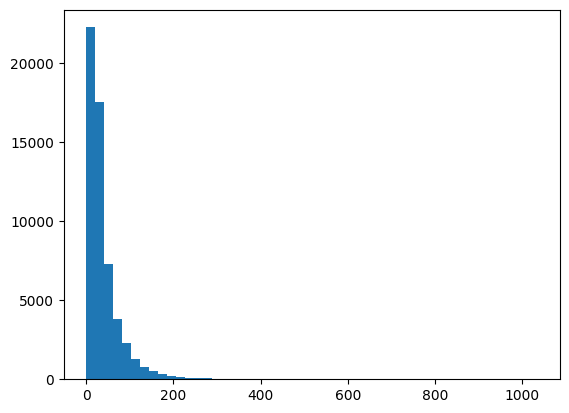

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

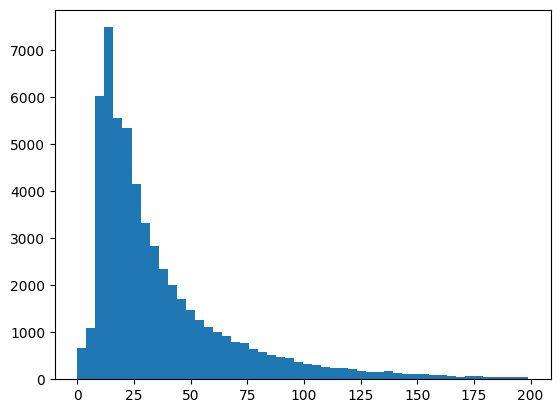

In [16]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

In [17]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (56835, 150)
Shape of data test tensor: (14209, 150)


In [18]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)


Shape of label tensor: (56835, 2)


In [19]:
# A simple supervised CBOW model in Keras
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [20]:
model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=128)

Epoch 1/10
400/400 [==============================] - 11s 25ms/step - loss: 0.3972 - acc: 0.8619 - val_loss: 0.3574 - val_acc: 0.8633
Epoch 2/10
400/400 [==============================] - 10s 26ms/step - loss: 0.3198 - acc: 0.8729 - val_loss: 0.3024 - val_acc: 0.8784
Epoch 3/10
400/400 [==============================] - 10s 26ms/step - loss: 0.2682 - acc: 0.8901 - val_loss: 0.2685 - val_acc: 0.8902
Epoch 4/10
400/400 [==============================] - 12s 30ms/step - loss: 0.2379 - acc: 0.9035 - val_loss: 0.2520 - val_acc: 0.8995
Epoch 5/10
400/400 [==============================] - 12s 29ms/step - loss: 0.2192 - acc: 0.9126 - val_loss: 0.2436 - val_acc: 0.9046
Epoch 6/10
400/400 [==============================] - 11s 28ms/step - loss: 0.2059 - acc: 0.9186 - val_loss: 0.2385 - val_acc: 0.9073
Epoch 7/10
400/400 [==============================] - 10s 24ms/step - loss: 0.1960 - acc: 0.9233 - val_loss: 0.2354 - val_acc: 0.9092
Epoch 8/10
400/400 [==============================] - 13s 33ms

In [21]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

445/445 [==============================] - 1s 2ms/step
test auc: 0.9130680218342808


In [22]:
# A complex model : LSTM
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(2, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [23]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=2, batch_size=128)

Epoch 1/2
400/400 [==============================] - 423s 1s/step - loss: 0.1833 - acc: 0.9330 - val_loss: 0.2451 - val_acc: 0.9122
Epoch 2/2
400/400 [==============================] - 422s 1s/step - loss: 0.1601 - acc: 0.9414 - val_loss: 0.2302 - val_acc: 0.9134


In [24]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

445/445 [==============================] - 28s 62ms/step
test auc: 0.9147070299937649


In [25]:
# A more complex model : CNN - LSTM
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# LSTM layer with a hidden size of 64
x = Dropout(0.2)(x)
x = LSTM(64)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [26]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=5, batch_size=128)

Epoch 1/5
400/400 [==============================] - 47s 110ms/step - loss: 0.1854 - acc: 0.9310 - val_loss: 0.2324 - val_acc: 0.9136
Epoch 2/5
400/400 [==============================] - 44s 109ms/step - loss: 0.1616 - acc: 0.9397 - val_loss: 0.2558 - val_acc: 0.9075
Epoch 3/5
400/400 [==============================] - 44s 109ms/step - loss: 0.1518 - acc: 0.9440 - val_loss: 0.2407 - val_acc: 0.9159
Epoch 4/5
400/400 [==============================] - 42s 106ms/step - loss: 0.1383 - acc: 0.9501 - val_loss: 0.2491 - val_acc: 0.9156
Epoch 5/5
400/400 [==============================] - 42s 106ms/step - loss: 0.1258 - acc: 0.9552 - val_loss: 0.2845 - val_acc: 0.9141


In [27]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

445/445 [==============================] - 5s 9ms/step
test auc: 0.8953580370263035


In [28]:
# Visualize the outputs of our own Embeddings
# We are going to use our precedent model for our embedding.
# Then we will pass our 100 first reviews in the embedding and plot them with the label.
from keras import backend as K
get_emb_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].input])
embedding_output = get_emb_layer_output([x_test[:3000]])[0]

In [29]:
emb_shape = embedding_output.shape
to_plot_embedding = embedding_output.reshape(emb_shape[0],emb_shape[1]*emb_shape[2])
y = y_test[:3000]

In [30]:
sentence_emb_tsne = TSNE(perplexity=30).fit_transform(to_plot_embedding)

In [31]:
print(sentence_emb_tsne.shape)
print(y.shape)

(3000, 2)
(3000,)


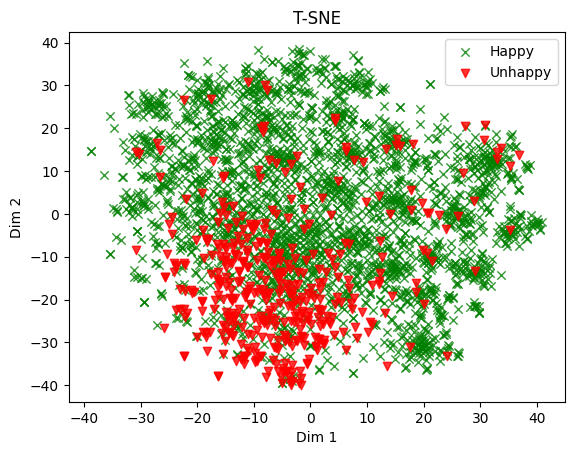

In [37]:
plt.figure()
plt.scatter(sentence_emb_tsne[np.where(y == 0), 0],
                   sentence_emb_tsne[np.where(y == 0), 1],
                   marker='x', color='g',
                   linewidth=1, alpha=0.8, label='Happy') # code fix for colab: linewidth parameter expects a numerical value, not a string '1'

plt.scatter(sentence_emb_tsne[np.where(y == 1), 0],
                   sentence_emb_tsne[np.where(y == 1), 1],
                   marker='v', color='r',
                   linewidth=1, alpha=0.8, label='Unhappy') # code fix for colab: linewidth parameter expects a numerical value, not a string '1'

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE')
plt.legend(loc='best')
plt.savefig('1.png')
plt.show()